In [27]:
import torch
import torch.nn.functional as F
import got_utils
import numpy as np
import pandas as pd
import os
import json
import time

from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset example
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


class CodingData:
    def __init__(self, ROOT):
        self.act = torch.from_numpy(np.load(os.path.join(ROOT, 'acts.npy'))) # (Samples, Layers, Dim)
        # with open(os.path.join(ROOT, 'labeled_data.json')) as f:
        #     self.data = json.load(f)
        self.data = pd.read_json(os.path.join(ROOT, 'labeled.json'))
        self.label_tensor = torch.zeros(self.act.shape[0])
        for i in range(len(self.data)):
            self.label_tensor[i] = int(self.data['label'][i])
        self.pcs = []
        for i in range(self.act.shape[1]):
            self.pcs.append(got_utils.get_pcs(self.act.T[:, i, :]))

    def get_dataloader(self, layer, batch_size=32):
        dataset = MyDataset(self.act[:, layer, :], self.label_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def plot_pcs(self, layer):
        scatter = plt.scatter(self.pcs[layer].numpy()[:,0], self.pcs[layer].numpy()[:,1], c=self.data['label'], cmap='tab20')
        # Create legend entries for True and False
        handles, _ = scatter.legend_elements()
        labels = ['False', 'True']
        
        # Add the legend with custom labels
        plt.legend(handles, labels)
        plt.show()

In [29]:
easy_data = CodingData('data/factual/easy_100/Llama_2_13b_chat_hf')
hard_data = CodingData('data/factual/hard_100/Llama_2_13b_chat_hf')

In [4]:
print(f'Easy Hallucination rate: {1 - easy_data.label_tensor.mean()}')
print(f'Hard Hallucination rate: {1 - hard_data.label_tensor.mean()}')   

Easy Hallucination rate: 0.616161584854126
Hard Hallucination rate: 0.6767677068710327


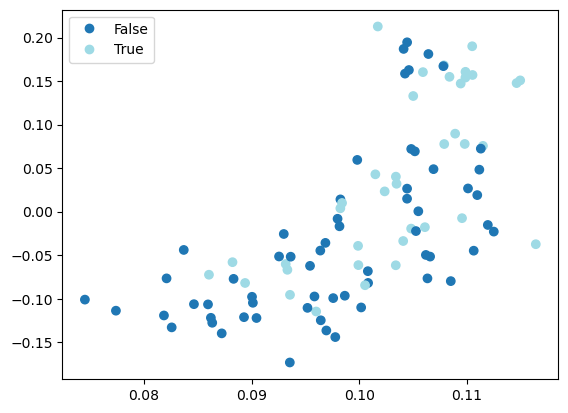

In [19]:
easy_data.plot_pcs(30)

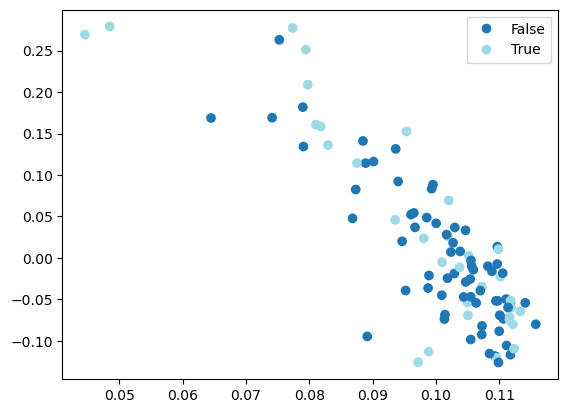

In [18]:
hard_data.plot_pcs(30)

## Visualization

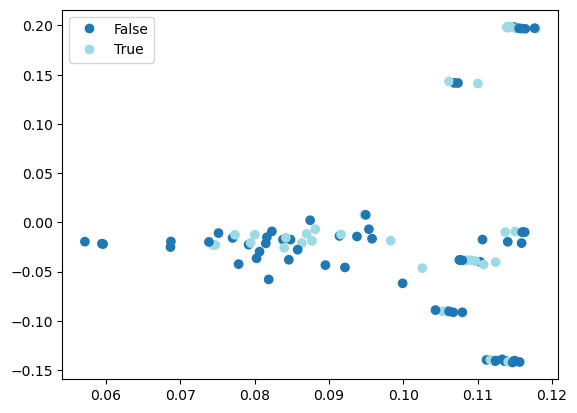

In [103]:
data.plot_pcs(1)

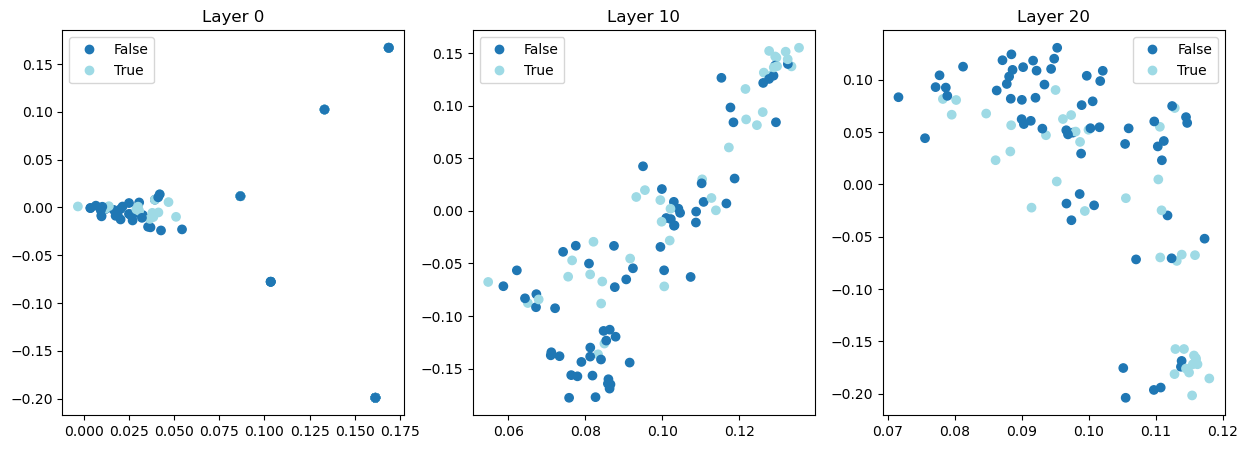

In [105]:
# put 10, 20, 30 in a subplot together
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    scatter = ax.scatter(data.pcs[10*i].numpy()[:,0], data.pcs[10*i].numpy()[:,1], c=data.data['label'], cmap='tab20')
    ax.set_title(f'Layer {10*i}')
    handles, _ = scatter.legend_elements()
    labels = ['False', 'True']
    ax.legend(handles, labels)

## Linear Probes

In [14]:
from probes import LinearProbe

In [110]:
probe = LinearProbe(data.act.shape[2], 2)

In [15]:
def train(probe, data, layer, epochs=1, lr=1e-3, device='cpu', batch_size=32):
    optimizer = torch.optim.Adam(probe.parameters(), lr=lr)
    losses = []
    accuracies = []
    for epoch in range(epochs):
        for x, y in tqdm(data.get_dataloader(layer, batch_size=32)):
            x = x.to(device)
            optimizer.zero_grad()
            y_hat = probe(x)
            loss = probe.loss(y_hat, y.long())
            accuracy = probe.accuracy(y_hat, y.long())
            accuracies.append(accuracy)
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    return losses, accuracies

In [172]:
x, y = next(iter(data.get_dataloader(0)))

In [155]:
x.shape

torch.Size([32, 4096])

In [156]:
y.shape

torch.Size([32])

In [129]:
y

tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [16]:
losses, accuracies = train(probeOne:=LinearProbe(data.act.shape[2], 2), data, 1, epochs=100, batch_size=8)

  0%|                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2 and 4096x2)

In [13]:
losses

[0.6907200813293457,
 0.684845507144928,
 0.6838812232017517,
 0.6994679570198059,
 0.665129542350769,
 0.6526782512664795,
 0.666519284248352,
 0.622318685054779,
 0.645872175693512,
 0.6726740598678589,
 0.612898051738739,
 0.6238868832588196,
 0.6552985310554504,
 0.5871312022209167,
 0.655422031879425,
 0.556605339050293,
 0.6424732804298401,
 0.6128851175308228,
 0.6060891151428223,
 0.5808897614479065,
 0.6373527646064758,
 0.6371457576751709,
 0.5678880214691162,
 0.4354316294193268,
 0.5517510771751404,
 0.6627371311187744,
 0.5846401453018188,
 0.6712687015533447,
 0.5370045900344849,
 0.6796383261680603,
 0.5768365859985352,
 0.4009714424610138,
 0.6336193680763245,
 0.526317298412323,
 0.6050977110862732,
 0.4503001272678375,
 0.6688522100448608,
 0.5352090001106262,
 0.5257655382156372,
 0.5737582445144653,
 0.5800584554672241,
 0.5685614943504333,
 0.5618613958358765,
 0.5884241461753845,
 0.57979816198349,
 0.5761747360229492,
 0.5464286804199219,
 0.4988088607788086,
 0.

In [159]:
y_hat = probeOne(x)

In [160]:
y_hat.shape

torch.Size([32, 2])

In [161]:
y.shape

torch.Size([32])

In [166]:
F.cross_entropy(y_hat, y.long())

tensor(0.6918, grad_fn=<NllLossBackward0>)

In [ ]:
probe = 

## Geometry of Truth Probes

In [34]:
from got_probes import LRProbe, MMProbe, CCSProbe

In [35]:
probe = LRProbe.from_data(easy_data.act[:, -1, :], easy_data.label_tensor.reshape(-1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3278.30it/s]


In [41]:
print(accuracy := (probe.pred(easy_data.act[:, -1, :]) == easy_data.label_tensor).float().mean())

tensor(1.)


In [45]:
test_accuracy = (probe.pred(hard_data.act[:, -1, :]) == hard_data.label_tensor).float().mean()

In [46]:
print(test_accuracy)

tensor(0.3737)
